In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import struct
import os
import sys

In [ ]:
transform_func = transforms.Compose([

    # I am commenting out the transforms which I am not using

    #transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 5 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image with padding
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert images to PyTorch tensors with pixel values in [0, 1]
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean(R,G,B), std deviation(R, G, B)
])

# get the CIFAR-10 train dataset into Drive
train_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/IvLabs VNIT/CIFAR-10 Dataset', train=True, download=True, transform=transform_func)

# get the CIFAR-10 test dataset into Drive
test_dataset = datasets.CIFAR10(root='/content/drive/MyDrive/IvLabs VNIT/CIFAR-10 Dataset', train=False, download=True, transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# creating a class for the CNN containing all the functions required
class CNN(nn.Module):

  ## defining the constructor of the parent class - nn.Module
  def __init__(self, in_channels=3, num_classes=10):
    # calling the constructor of the parent class - nn.Module
    super(CNN, self).__init__()

    ## defining the layers of the CNN

    # i/p dimension: (32*32*3)
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # "same" conv
    # o/p dimension: (32*32*32)
    self.bn1 = nn.BatchNorm2d(32)

    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    # o/p dimension: (16*16*32)
    self.dropout1 = nn.Dropout(0.2)

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # "Same" conv
    # o/p dimension: (16*16*64)
    self.bn2 = nn.BatchNorm2d(64)

    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    # o/p dimension: (8*8*128)
    self.dropout2 = nn.Dropout(0.2)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) # "Same" conv
    # o/p dimension: (8*8*128)
    self.bn3 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(8*8*128, 1024*4)
    self.fc2 = nn.Linear(1024*4, 1024)
    self.fc3 = nn.Linear(1024, 128)
    self.fc4 = nn.Linear(128, num_classes)

  ## defining the forward propagation of the CNN
  def forward(self, x):

    x = F.relu(self.bn1(self.conv1(x)))
    x = self.dropout1(self.pool1(x))

    x = F.relu(self.bn2(self.conv2(x)))
    x = self.dropout2(self.pool2(x))

    x = F.relu(self.bn3(self.conv3(x)))

    x = x.reshape(x.shape[0], -1) # to flatten out for the FCL
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)

    return x

In [ ]:
# check accuracy with train set and/or test set
def check_accuracy(loader, model, i):
  # setting the model to eval mode - regularisation, normalisation is stopped.
  model.eval()
  num_correct = 0
  num_samples = 0

  with torch.no_grad():
    for data, targets in loader:
      data = data.to(device=device)
      targets = targets.to(device=device)
      #data = data.reshape(data.shape[0], -1)

      predictions = model(data)
      _, predictions = predictions.max(1)
      num_correct += (predictions == targets).sum()
      num_samples += predictions.size(0)

  acc  = float(num_correct)/float(num_samples)*100
  model.train() # setting back model to train mode.
  return acc


In [ ]:
# to specify the device which which process the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 0.0001
batch_size = 1024
num_epochs = 100


# import the CIFAR-10 from Drive to PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# initialising the network by creating an instance of the class CNN
model = CNN().to(device)

# loss function
# CrossEntropyLoss function implicitly applies softmax first, then calculates negative log likelihood loss
# hence we need not call the softmax function explicitly.
loss_func = nn.CrossEntropyLoss()


# Adam Optimiser
# model.parameters() to retrieve all the parameters of a NN model
optimiser = optim.Adam(model.parameters(), lr=learning_rate)


# training the network
cost_lst = []
accu_lst1 = [] # to store accuracy of model on train set after every epoch
accu_lst2 = [] # to store accuracy of model on test set after every epoch

for epoch in range(num_epochs):

  loss_epoch = 0
  for batch_index, (data, targets) in enumerate(train_loader):
    data = data.to(device=device)
    targets = targets.to(device=device)
                                          #data = data.reshape(data.shape[0], -1)
    # forward propagation
    predictions = model(data)
    loss = loss_func(predictions, targets)
    loss_epoch += loss.item()

    # backward propagation
    optimiser.zero_grad() # zero_grad to set gradients back to 0 after every batch
    loss.backward() # weight updation

    # gradient descent through adam optimiser algo
    optimiser.step()

  cost_epoch = loss_epoch/len(train_loader)
  cost_lst.append(cost_epoch)
  # printing the cost after every epoch
  print(f"Cost after epoch {epoch+1}: {cost_epoch}")

  if((epoch+1)%5 == 0):
    # checking accuracy after every epoch
    accu1 = check_accuracy(train_loader, model, epoch+1) # on train set
    accu_lst1.append(accu1)
    print(f"Accuracy on train set after epoch {epoch+1}: {float(accu1):.2f}")

    accu2 = check_accuracy(test_loader, model, epoch+1) # on test set
    accu_lst2.append(accu2)
    print(f"Accuracy on test set after epoch {epoch+1}: {float(accu2):.2f}\n")


Cost after epoch 1: 1.8387721071437912
Cost after epoch 2: 1.5345902783530099
Cost after epoch 3: 1.4085451607801476
Cost after epoch 4: 1.3396745093014775
Cost after epoch 5: 1.2714023955014286
Accuracy on train set after epoch 5: 49.19
Accuracy on test set after epoch 5: 52.89

Cost after epoch 6: 1.2237215334055376
Cost after epoch 7: 1.179320374313666
Cost after epoch 8: 1.1458469142719192
Cost after epoch 9: 1.1084140125586062
Cost after epoch 10: 1.0850769086759917
Accuracy on train set after epoch 10: 50.93
Accuracy on test set after epoch 10: 53.86

Cost after epoch 11: 1.0508823540745948
Cost after epoch 12: 1.0238306060129283
Cost after epoch 13: 1.00304626445381
Cost after epoch 14: 0.9805719572670606
Cost after epoch 15: 0.9527380819223366
Accuracy on train set after epoch 15: 53.55
Accuracy on test set after epoch 15: 55.76

Cost after epoch 16: 0.9466150463843832
Cost after epoch 17: 0.922967500832616
Cost after epoch 18: 0.9045288733073643
Cost after epoch 19: 0.89434544

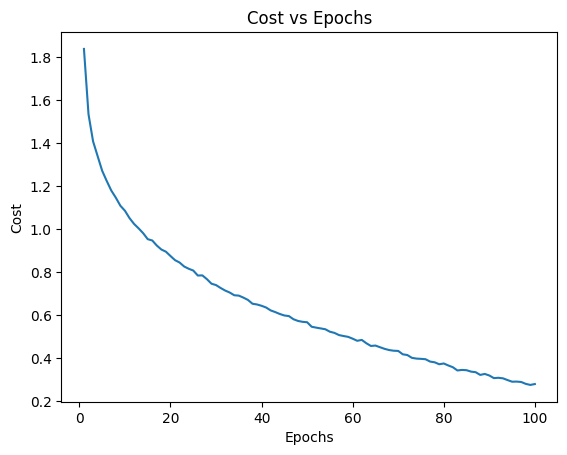

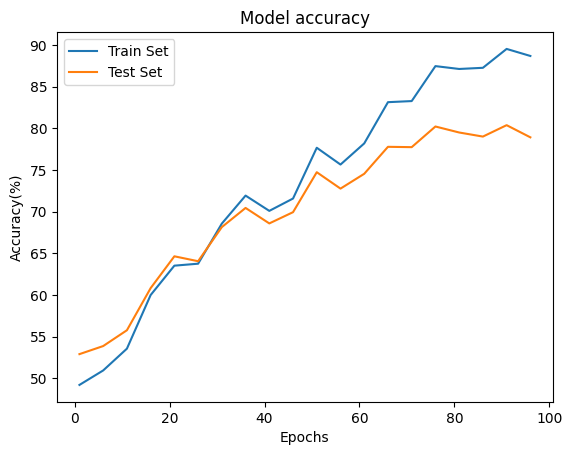

In [ ]:
# to plot the cost vs epochs graph
t = np.arange(1, num_epochs+1)
plt.plot(t, cost_lst)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs Epochs")
plt.show()

# to plot the Model accuracy on train set vs epochs
t2 = np.arange(1, num_epochs+1, 5) # since accuracy was calculated every 5th epoch
plt.plot(t2, accu_lst1, label='Train Set')
# to plot the Model accuracy on test set vs epochs
plt.plot(t2, accu_lst2, label='Test Set')

plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.title("Model accuracy")
plt.legend()
plt.show()